In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import json
import re

import hdbscan
import umap 
from sklearn.mixture import GaussianMixture as GMM
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
%matplotlib inline
print('loaded')

loaded


In [11]:
user_artists_df = pd.read_csv('/Users/aagmon/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv', sep='\t')
user_artists_df.columns = ['user', 'artist_id', 'artist', 'plays']
user_artists_df = user_artists_df.loc[:, ['user', 'artist']]

In [12]:
user_artists_df.sample(n=15)

,user,artist
390411,05bf7d35e25c1ecd9d6b8eedca5200c193492631,social distortion
2568541,25946a8c275e71f3d5e5be3cb5a2ccd3fa42092b,moby
13259665,c1d54b24af6be9e7bfc4744e78ae09c04246e423,prinz pi
2807157,291148dcd8bce0c9523f69bf590bb0ce8b7a2734,congo natty
17519156,ffbbd9e0a6c65bf15f076e8c97fe9c94cdfe456c,slayer
16029192,ea277885f76a90441e196212753e6cbff1365a1e,mj cole
12511096,b6d97a2d98499cedb6dc37bec4363d4ec50145d0,the breeders
11280738,a4f348a215581a7985b1a0c95bdb338f75831756,the last shadow puppets
5461719,4ff280a77c1ff12f1c8d87f64aff1037b362fcf5,corpus delicti
14804873,d81ec793ea571356481c755b11a347e91ee782cc,einstürzende neubauten


In [13]:
# clear the most popular artist

n_1perc = 25
print(f'Clearning {n_1perc} artists')

df_top = user_artists_df.groupby(['artist'])['user'].count().reset_index()
top_titles = df_top.sort_values(by='user', ascending=False)[:n_1perc]['artist'].values

user_item_df = user_artists_df[~user_artists_df['artist'].isin(top_titles)]
print('removed:',top_titles )

Clearning 25 artists
removed: ['radiohead' 'the beatles' 'coldplay' 'red hot chili peppers' 'muse'
 'metallica' 'pink floyd' 'the killers' 'linkin park' 'nirvana'
 'system of a down' 'queen' 'u2' 'daft punk' 'the cure' 'led zeppelin'
 'placebo' 'depeche mode' 'david bowie' 'bob dylan' 'death cab for cutie'
 'arctic monkeys' 'foo fighters' 'air' 'the rolling stones']


In [16]:
%%time
# prepare a narrower user X item DF
grp_users = user_item_df.groupby(['user']).indices 

CPU times: user 1h 24min 24s, sys: 7min 54s, total: 1h 32min 18s
Wall time: 1h 33min 24s


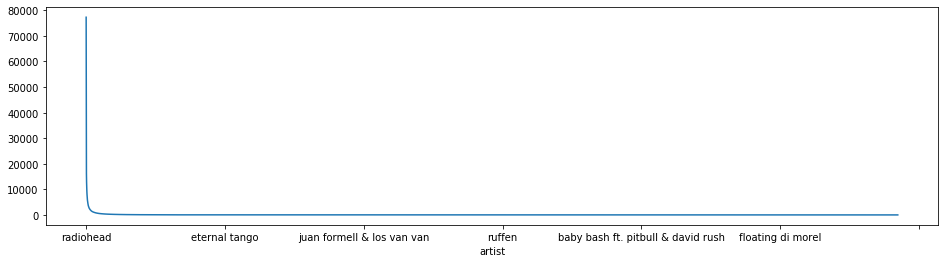

In [17]:
plt.rcParams['figure.figsize'] = [16, 4]
user_artists_df.groupby('artist')['user'].count().sort_values(ascending=False).plot()

In [18]:
# use pickle to save the grp_users dict due to its size

import pickle
# Store data (serialize)
with open('grp_users_25.pickle', 'wb') as handle:
    pickle.dump(grp_users, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
#with open('grp_users_05.pickle', 'rb') as handle:
#    grp_users = pickle.load(handle)

In [19]:
%%time
#create the main data struc for W2V - a dict with user ID as key and value is a list of artists
# user id => artists

text_parts = {}
for user in tqdm(grp_users):
    item_ix = np.array(grp_users[user])
    items = user_item_df.iloc[item_ix]
    text_parts[user] = list(items['artist'].values)

100%|██████████| 358867/358867 [01:06<00:00, 5387.39it/s]

CPU times: user 1min 2s, sys: 3.7 s, total: 1min 5s
Wall time: 1min 6s


In [20]:
# max # of engagements per user - to calculate the size of the window
max_num_views = np.quantile( [len(views) for views in text_parts.values()], 0.95)
print(f'max num of progs: {max_num_views}')

max num of progs: 60.0


In [21]:
# util funtions

# dim reduction using UMAP
def learn_manifold(data, umap_min_dist=0.25, umap_metric='euclidean', umap_dim=10, umap_neighbors=30):
    md = float(umap_min_dist)
    reducer =  umap.UMAP(
        random_state=0,
        metric=umap_metric,
        n_components=umap_dim,
        n_neighbors=umap_neighbors,
        min_dist=md).fit(data)
    return reducer, reducer.transform(data)

#clusering using GMM
def cluster_gmm(matrix, k=4):
    gmm_model = GMM(k, covariance_type='full', random_state=0, n_init=10)
    gmm_model.fit(matrix)
    gmm_labels = gmm_model.predict(matrix)
    centers = gmm_model.means_
    return gmm_model, gmm_labels, centers 


#clusering using HDBSCAN
def cluster_hdbscan(matrix, min_cluster_size=300, min_samples=30):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(matrix)
    hdbs_labels = clusterer.labels_
    hdbs_centers = clusterer.exemplars_
    return clusterer, hdbs_labels, hdbs_centers


def visualize_clusters(matrix_2d, labels):
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    scatter = ax.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=labels, cmap='tab20', alpha=0.65)
    # produce a legend 
    legend = ax.legend(*scatter.legend_elements(), title="Clusters", prop={'size': 12})
    ax.add_artist(legend)

    viz_clusters = pd.DataFrame(matrix_2d)
    viz_clusters['cluster'] = labels
    print(viz_clusters['cluster'].value_counts())

In [22]:
# take a sample of the dic just to shorten the rest
n_sample = 50000
original_text_parts = text_parts
sample_ids = np.random.choice(text_parts.__len__(), n_sample, replace=False)
sample_users = np.array(list(text_parts.keys()))[sample_ids]
text_parts = {user:text_parts[user] for user in sample_users}

In [23]:
# generate the embedding using W2V

vec_size = 36
word_window = max_num_views

### Word2Vec
exp_model = Word2Vec(text_parts.values(), min_count=3, vector_size=vec_size,
                     workers=12, negative=10, window=word_window, sg=1, ns_exponent=0.5)

In [24]:
exp_model.wv['robert schumann']

array([ 0.27116495,  0.69146776, -0.546462  ,  0.03881299, -0.7307844 ,
        0.12465341, -0.70144796, -0.00300584,  0.30210793, -0.14575703,
       -0.22088838,  0.3413829 , -0.02061589, -0.5691442 , -1.1192286 ,
        0.00970382,  0.22024882, -0.3862614 ,  0.42381513,  0.01146795,
       -0.6089754 ,  0.37262914, -0.40289983,  0.19234097,  1.2354873 ,
       -0.8932213 ,  0.09755038, -1.0649027 ,  0.78794914, -0.24419682,
       -0.35103732, -0.64270854,  0.28867975,  0.95562345, -0.7082881 ,
       -0.5544146 ], dtype=float32)

In [25]:
exp_model.wv.most_similar('robert schumann')

[('johannes brahms', 0.9437376260757446),
 ('camille saint-saëns', 0.9386627674102783),
 ('sir edward elgar', 0.9369467496871948),
 ('jean sibelius', 0.9337591528892517),
 ('sergei rachmaninoff', 0.927741527557373),
 ('gustav mahler', 0.9276910424232483),
 ('franz joseph haydn', 0.9252969622612),
 ('felix mendelssohn', 0.9245099425315857),
 ('sergei prokofiev', 0.9235916137695312),
 ('antonín dvořák', 0.922497570514679)]

In [26]:
exp_model.wv.most_similar('miles davis quintet')

[('horace silver', 0.9214020371437073),
 ('warne marsh', 0.9172077775001526),
 ('mccoy tyner', 0.9107123613357544),
 ('sonny clark', 0.907101571559906),
 ('shelly manne', 0.9064918160438538),
 ('dexter gordon', 0.9054291248321533),
 ('booker ervin', 0.9049861431121826),
 ('thad jones', 0.9030550122261047),
 ('wayne shorter', 0.9024197459220886),
 ('charlie rouse', 0.9014986157417297)]

In [27]:
jazz_miles = exp_model.wv["miles davis quintet"] 
jazz_sonny = exp_model.wv['sonny rollins']

classic_schumann = exp_model.wv['robert schumann']
classic_mahler = exp_model.wv['gustav mahler']

user = np.mean([jazz_miles, classic_mahler, jazz_sonny, classic_schumann], axis=0)

In [28]:
exp_model.wv.similar_by_vector(user, topn=10)

[('miles davis quintet', 0.8966612815856934),
 ('robert schumann', 0.8933537006378174),
 ('elliott carter', 0.8932778835296631),
 ('leroy anderson', 0.8926759958267212),
 ('maurice ravel', 0.8906748294830322),
 ('felix mendelssohn', 0.8888518810272217),
 ('tommy flanagan trio', 0.8882997632026672),
 ('charles-valentin alkan', 0.8852038383483887),
 ('gustav mahler', 0.8850896954536438),
 ('heinz holliger', 0.8818747997283936)]

In [29]:
%%time
# generate the data structs to hold the relevant data

user_means = {}
users_keys = []

for user in tqdm(list(text_parts.keys())):
    hh_artists = [artist for artist in text_parts[user] if exp_model.wv.has_index_for(artist)]
    if len(hh_artists) == 0:
        continue
    hh_mean = np.mean(exp_model.wv[hh_artists], axis=0)
    user_means[user] = hh_mean
    users_keys.append(user)

100%|██████████| 50000/50000 [00:07<00:00, 6424.25it/s]

CPU times: user 7.54 s, sys: 181 ms, total: 7.72 s
Wall time: 7.81 s


In [30]:
# create the users matrix as numpy array
matrix_users = np.zeros((len(user_means),exp_model.vector_size ))
for ix, key in tqdm(enumerate(user_means.keys())):
    matrix_users[ix] = user_means[key]

50000it [00:00, 780300.79it/s]


### 1. Simple clustering of the embedding

In [32]:
# cluser the data
user_model, user_labels, user_cluster_centers = cluster_hdbscan(matrix_users)

In [33]:
reducer_2d_users, reduced_users_2d = \
    learn_manifold(matrix_users, umap_min_dist=0.5, umap_metric='euclidean', umap_dim=2, umap_neighbors=50)

-1    50000
Name: cluster, dtype: int64


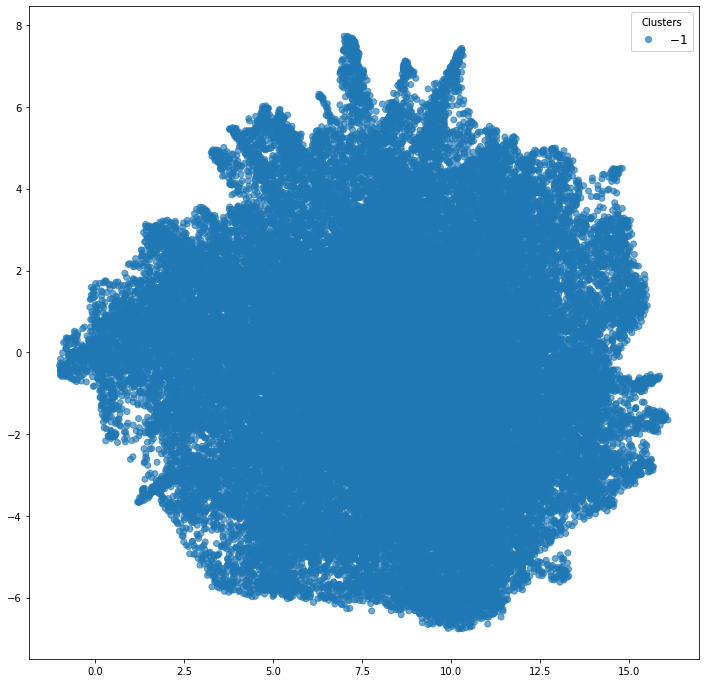

In [34]:
visualize_clusters(reduced_users_2d, user_labels)

### 2.  Clustering using Gaussian Mixture model 

#### 2.1  Cluster items - start by identifying the optimal K

100%|██████████| 12/12 [37:57<00:00, 189.80s/it]


Best K that minimizes davies_bouldin in range: 12


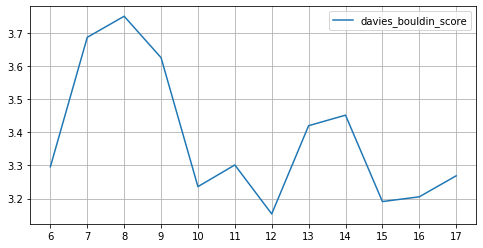

In [37]:

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

def print_score(Ks, scores):
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.plot(Ks,scores, label='davies_bouldin_score' )
    plt.xticks(Ks)
    plt.grid()
    plt.legend()
    plt.show()

#sample_ids = np.random.choice(range(len(exp_model.wv.vectors)), 2000, replace=False)
sample = exp_model.wv.vectors #ar_users_clusters[sample_ids, :]
Ks = []
scores = []
for k in tqdm(range(6,18)):
    model, labels, cluster_centers = cluster_gmm(exp_model.wv.vectors, k=k)
    b_score = davies_bouldin_score(exp_model.wv.vectors, labels)
    Ks.append(k)
    scores.append(b_score)
    
print('Best K that minimizes davies_bouldin in range:', Ks[np.where(scores == min(scores))[0][0]])
print_score(Ks, scores)

#### 2.2  learn Gaussian mixture model and cluster the items

In [38]:

items_model, items_labels, items_cluster_centers = cluster_gmm(exp_model.wv.vectors, k=12)

#### 2.3 generate the new user vectors

In [39]:

ar_users_clusters = np.zeros((len(user_means), items_cluster_centers.shape[0]))

for ix, user_key in enumerate(user_means):
    user_mean = user_means[user_key]
    ar_users_clusters[ix] = items_model.predict_proba([user_mean])

100%|██████████| 12/12 [01:14<00:00,  6.21s/it]


Best K that minimizes davies_bouldin in range: 12


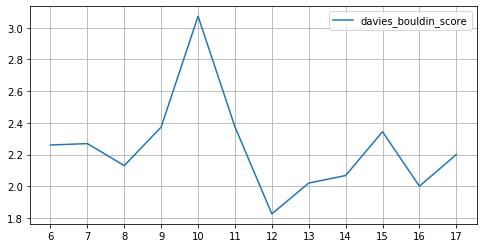

In [40]:
# check for the optimal K of the users - just to be able to compare

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

sample_ids = np.random.choice(range(len(ar_users_clusters)), 5000, replace=False)
sample = ar_users_clusters[sample_ids, :]
Ks = []
scores = []
for k in tqdm(range(6,18)):
    model, labels, cluster_centers = cluster_gmm(sample, k=k)
    #a_score = calinski_harabasz_score(sample, labels)
    b_score = davies_bouldin_score(sample, labels)
    Ks.append(k)
    scores.append(b_score)
    
print('Best K that minimizes davies_bouldin in range:', Ks[np.where(scores == min(scores))[0][0]])
print_score(Ks, scores)

#### 2.4 cluster the users 

In [41]:

user_model, user_labels, user_cluster_centers = \
     cluster_hdbscan(ar_users_clusters)

In [42]:
reducer_2d_users, reduced_users_2d = \
    learn_manifold(ar_users_clusters, umap_min_dist=0.5, umap_metric='euclidean', umap_dim=2, umap_neighbors=50)

 9     11346
-1     10402
 10     4829
 8      4700
 4      4410
 3      3007
 6      2516
 1      2115
 7      1940
 5      1668
 0      1596
 2      1471
Name: cluster, dtype: int64


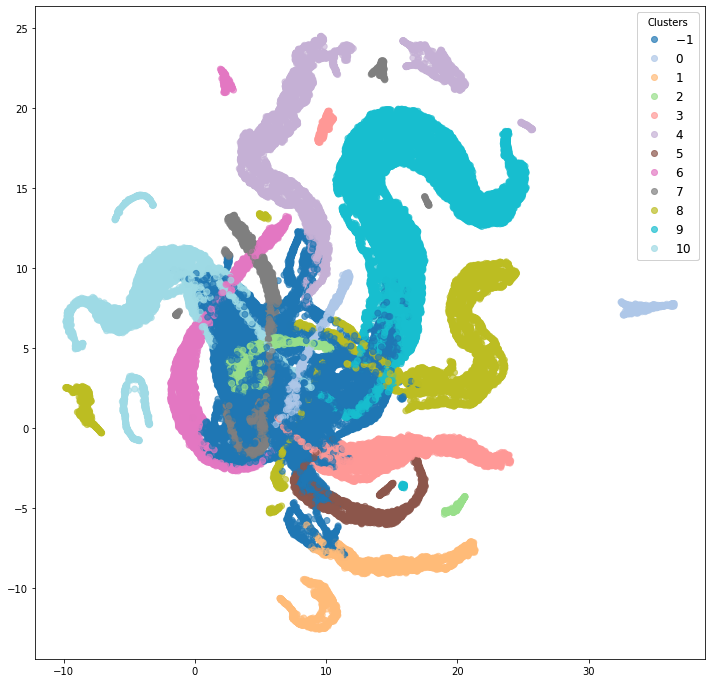

In [43]:
visualize_clusters(reduced_users_2d, user_labels)

In [44]:
# filtered df = user_item_df
# unfiltered = user_artists_df

for prog_cid in range(len(user_model.exemplars_)):
    cluster_user_ids = np.where(user_labels == prog_cid)[0]
    cluster_users = [users_keys[user_id] for user_id in cluster_user_ids]
    top_cluster_artists = user_item_df.loc[user_item_df['user'].isin(cluster_users)]\
        .groupby('artist')['user'].count()\
        .sort_values(ascending=False)
    top_cluster_artists = top_cluster_artists / np.sum(top_cluster_artists.values) * 100
    print('-------------------')
    print()
    print('Cluster: ', prog_cid)
    print(top_cluster_artists[:15])
    print()

-------------------

Cluster:  0
artist
myslovitz        0.432195
pidżama porno    0.387330
happysad         0.376862
hey              0.369384
akurat           0.367889
coma             0.348448
sezen aksu       0.315547
teoman           0.309565
kult             0.305079
duman            0.302088
[unknown]        0.300592
bob marley       0.281151
o.s.t.r.         0.279655
t.love           0.276664
dżem             0.257223
Name: user, dtype: float64

-------------------

Cluster:  1
artist
amy winehouse              0.404036
andrés calamaro            0.336697
chico buarque              0.336697
manu chao                  0.335645
los hermanos               0.316705
the strokes                0.315653
oasis                      0.293558
marisa monte               0.290401
soda stereo                0.274618
bob marley                 0.271462
café tacuba                0.267253
caetano veloso             0.261992
franz ferdinand            0.259888
los fabulosos cadillacs    0.25778

### 3.  Use manifold learning before clustering

In [49]:
%%time
#reduce dims to 10
print('original size: ', matrix_users.shape)
reducer, reduced_embedding = learn_manifold(matrix_users, umap_min_dist=0.0, umap_metric='euclidean', umap_dim=10)

original size:  (50000, 36)
CPU times: user 1min 49s, sys: 13.3 s, total: 2min 2s
Wall time: 1min 32s


In [53]:
%%time
#cluster after dims reduced 
user_model, user_labels, user_cluster_centers = \
     cluster_hdbscan(reduced_embedding)

CPU times: user 2.23 s, sys: 157 ms, total: 2.39 s
Wall time: 4.56 s


In [51]:
reducer_2d_users, reduced_users_2d = \
    learn_manifold(reduced_embedding, umap_min_dist=0.5, umap_metric='euclidean', umap_dim=2, umap_neighbors=50)

-1    47191
 1     1818
 0      991
Name: cluster, dtype: int64


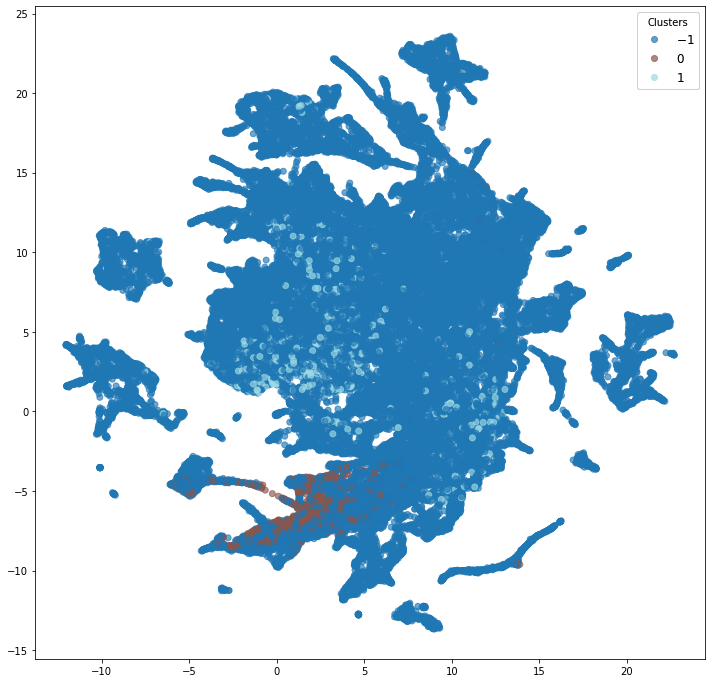

In [52]:
visualize_clusters(reduced_users_2d, user_labels)

### 4.  Use log transform before clustering

In [45]:
from sklearn.preprocessing import StandardScaler
from numpy import ma

log_matrix_user = ma.log(matrix_users)
log_matrix_user = log_matrix_user.filled(0)

scaler = StandardScaler()
scaled_log_matrix_users = scaler.fit_transform(log_matrix_user)

In [46]:
%%time
#cluster after dims reduced 
user_model, user_labels, user_cluster_centers = \
     cluster_hdbscan(scaled_log_matrix_users)

CPU times: user 3min 29s, sys: 802 ms, total: 3min 30s
Wall time: 3min 53s


In [47]:
reducer_2d_users, reduced_users_2d = \
    learn_manifold(scaled_log_matrix_users, umap_min_dist=0.5, umap_metric='euclidean', umap_dim=2, umap_neighbors=50)

-1    47191
 1     1818
 0      991
Name: cluster, dtype: int64


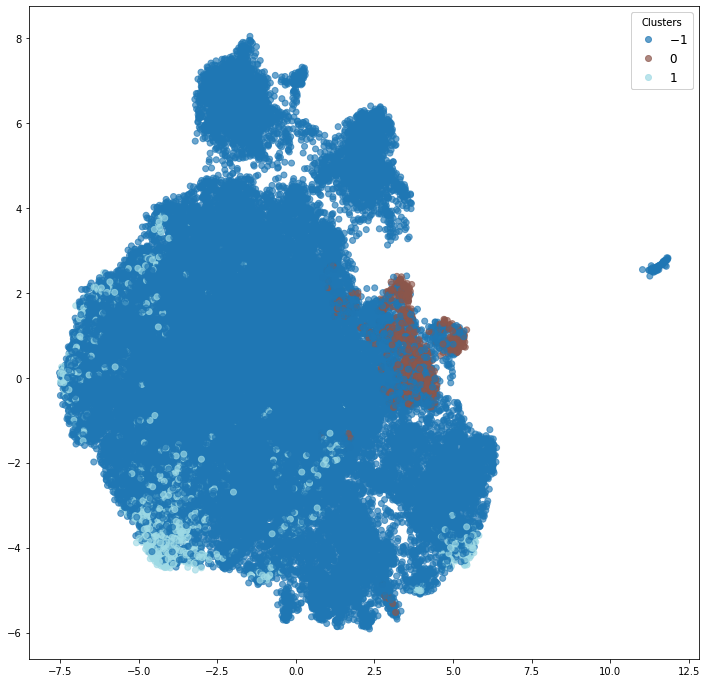

In [48]:
visualize_clusters(reduced_users_2d, user_labels)